### Netflix Prize Dataset EDA

In this notebook, we will primarily be performing some exploratory data analysis on the Netflix Prize dataset.

Our initial questions that we want to explore with this data set:
1. What are the most rated movies
2. What are the most POORLY rated movies? What are the most Well rated movies?
3. Who are these “top 10k” users?

#### Key Imports

In [1]:
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import glob

In [2]:
DATA_PATH = "../data"
NETFLIX_FOLDER_PATH = os.path.join(DATA_PATH, "netflix_prize")
MAPPING_PATH = os.path.join(DATA_PATH, "netflix_to_imdb.json")

## What are the most rated movies?
- Plot the distribution for a better view.

In [3]:
def load_valid_movies(mapping_path):
    """Load the netflix to IMDB mapping to get valid movie IDs"""
    with open(mapping_path, 'r') as f:
        netflix_to_imdb = json.load(f)
    return set(netflix_to_imdb.keys())  # Convert to set for faster lookups

In [4]:
def process_rating_file(filepath, valid_movie_ids):
    """Process a single rating file and count ratings for movies in our mapping"""
    ratings_count = 0
    
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if not line.endswith(':'):  # Skip user ID lines
                try:
                    movie_id, _, _ = line.split(',')
                    # Convert movie_id to string to match mapping format
                    if str(movie_id) in valid_movie_ids:
                        ratings_count += 1
                except ValueError:
                    continue
    
    return ratings_count

def analyze_ratings_distribution(netflix_folder, mapping_path):
    """Analyze rating counts distribution for mapped movies"""
    # Load valid movie IDs (these are the keys in the mapping)
    with open(mapping_path, 'r') as f:
        netflix_to_imdb = json.load(f)
    valid_movie_ids = set(netflix_to_imdb.keys())  # These are Netflix movie IDs
    print(f"Found {len(valid_movie_ids)} movies in netflix_to_imdb mapping")
    print(f"Sample movie IDs: {list(valid_movie_ids)[:5]}")  # Debug print
    
    # Process all files
    user_ratings = defaultdict(int)
    
    # Get list of files - using full path for training_set directory
    training_set_path = os.path.join(netflix_folder, 'training_set')
    files = glob.glob(os.path.join(training_set_path, 'mv_*.txt'))
    print(f"\nFound {len(files)} rating files")
    
    # Process each file
    total_ratings = 0
    for filepath in tqdm(files, desc="Processing rating files"):
        # Process the file directly using the full filepath
        ratings_count = process_rating_file(filepath, valid_movie_ids)
        
        if ratings_count > 0:
            # Extract user ID from filename
            filename = os.path.basename(filepath)
            user_id = filename.replace('mv_', '').replace('.txt', '')
            user_ratings[user_id] = ratings_count
            total_ratings += ratings_count
    
    print(f"\nTotal users with ratings: {len(user_ratings)}")
    print(f"Total ratings for mapped movies: {total_ratings}")
    
    return user_ratings

def plot_ratings_distribution(user_ratings):
    """Create visualization of ratings distribution"""
    if not user_ratings:
        raise ValueError("No ratings data found!")
        
    ratings_counts = list(user_ratings.values())
    
    # Create figure
    plt.figure(figsize=(12, 6))
    
    # Plot histogram with KDE
    sns.histplot(ratings_counts, bins=50, kde=True)
    
    # Add vertical line for mean
    mean_ratings = sum(ratings_counts) / len(ratings_counts)
    plt.axvline(mean_ratings, color='r', linestyle='--', 
                label=f'Mean: {mean_ratings:.1f}')
    
    # Add vertical line for median
    median_ratings = sorted(ratings_counts)[len(ratings_counts)//2]
    plt.axvline(median_ratings, color='g', linestyle='--', 
                label=f'Median: {median_ratings:.1f}')
    
    # Customize plot
    plt.title('Distribution of Ratings per User\n(Only for Movies in netflix_to_imdb Mapping)')
    plt.xlabel('Number of Ratings')
    plt.ylabel('Count of Users')
    plt.legend()
    
    # Print statistics
    print(f"\nStatistics:")
    print(f"Total users: {len(ratings_counts):,}")
    print(f"Mean ratings per user: {mean_ratings:.1f}")
    print(f"Median ratings per user: {median_ratings:.1f}")
    print(f"Max ratings by a user: {max(ratings_counts):,}")
    print(f"Total ratings: {sum(ratings_counts):,}")
    
    plt.show()

Found 9445 movies in netflix_to_imdb mapping
Sample movie IDs: ['5727', '10502', '10684', '14839', '9789']

Found 17770 rating files


Processing rating files: 100%|██████████| 17770/17770 [00:37<00:00, 478.68it/s]



Total users with ratings: 13733
Total ratings for mapped movies: 357412

Statistics:
Total users: 13,733
Mean ratings per user: 26.0
Median ratings per user: 4.0
Max ratings by a user: 837
Total ratings: 357,412


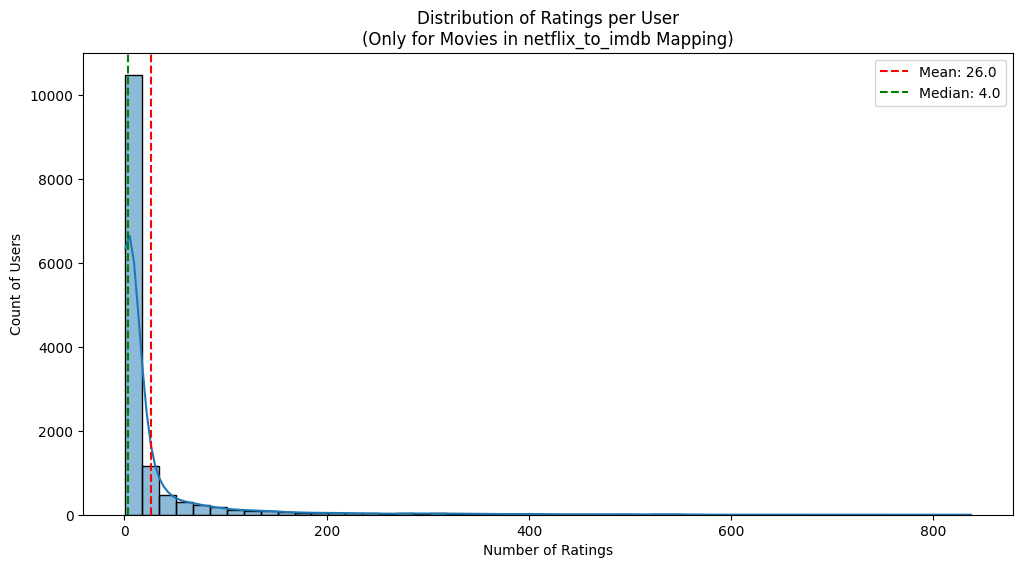

In [5]:
user_ratings = analyze_ratings_distribution(NETFLIX_FOLDER_PATH, MAPPING_PATH)

# Plot distribution
if user_ratings:
    plot_ratings_distribution(user_ratings)
else:
    print("No ratings found! Please check the paths and file format.")

### Among the top 10k, what are the most WELL rated movies?
- Where we are only analyzing the top 10k users
- We will plot the top k users with the most ratings. It will be displayed with a stacked barplot showing only high_ratings and low_ratings.

In [6]:
TOP_USER_PATH = os.path.join(DATA_PATH, "top_netflix_users.json")

In [7]:
def load_top_users(filepath):
    """Load top users data from JSON file."""
    with open(filepath, 'r') as f:
        return json.load(f)

def process_ratings_file(filepath, user_ratings, top_users_dict):
    """Process a single ratings file and update user_ratings."""
    with open(filepath, 'r') as f:
        # First line contains movie ID
        f.readline().strip(':\n')
        
        # Process each rating
        for line in f:
            user_id, rating, _ = line.strip().split(',')
            if user_id in top_users_dict:
                rating = int(rating)
                if rating >= 4:
                    user_ratings[user_id]['high_ratings'] += 1
                else:
                    user_ratings[user_id]['low_ratings'] += 1

def analyze_user_ratings(netflix_folder, top_users_dict):
    """Process all rating files and return DataFrame with user rating statistics."""
    # Initialize ratings dictionary
    user_ratings = {user_id: {'high_ratings': 0, 'low_ratings': 0} 
                   for user_id in top_users_dict.keys()}
    
    # Get rating files
    rating_files = glob.glob(os.path.join(netflix_folder, 'training_set', 'mv_*.txt'))
    print(f"Found {len(rating_files)} rating files")
    
    # Process all files
    for filepath in tqdm(rating_files):
        process_ratings_file(filepath, user_ratings, top_users_dict)
    
    # Convert to DataFrame
    ratings_df = pd.DataFrame.from_dict(user_ratings, orient='index')
    ratings_df['total_ratings'] = ratings_df['high_ratings'] + ratings_df['low_ratings']
    
    # Calculate ratios
    ratings_df['high_ratio'] = np.where(
        ratings_df['total_ratings'] > 0,
        ratings_df['high_ratings'] / ratings_df['total_ratings'],
        0
    )
    
    # Sort by total ratings
    return ratings_df.sort_values('total_ratings', ascending=False)

def analyze_and_save_movie_ratings(netflix_folder, output_path):
    """
    Analyze movie ratings and save a JSON file with total, high, and low ratings counts.
    High ratings are 4-5, low ratings are 1-3.
    """
    # Initialize ratings dictionary
    movie_ratings = {}
    
    print("Processing rating files...")
    rating_files = glob.glob(os.path.join(netflix_folder, 'training_set', 'mv_*.txt'))
    print(f"Found {len(rating_files)} rating files")
    
    # Process each ratings file
    for filepath in tqdm(rating_files):
        with open(filepath, 'r') as f:
            # First line contains movie ID
            movie_id = f.readline().strip(':\n')
            
            if movie_id not in movie_ratings:
                movie_ratings[movie_id] = {
                    'total_ratings': 0,
                    'high_ratings': 0,
                    'low_ratings': 0
                }
            
            # Process each rating
            for line in f:
                _, rating, _ = line.strip().split(',')
                rating = int(rating)
                
                movie_ratings[movie_id]['total_ratings'] += 1
                if rating >= 4:
                    movie_ratings[movie_id]['high_ratings'] += 1
                else:
                    movie_ratings[movie_id]['low_ratings'] += 1
    
    # Convert to list and sort by total_ratings descending
    sorted_ratings = [
        {'movie_id': movie_id, **stats}
        for movie_id, stats in movie_ratings.items()
    ]
    sorted_ratings.sort(key=lambda x: x['total_ratings'], reverse=True)
    
    # Save to JSON file
    with open(output_path, 'w') as f:
        json.dump(sorted_ratings, f, indent=4)
    
    print(f"\nSaved ratings data for {len(movie_ratings)} movies to {output_path}")
    
    # Print some summary statistics
    print("\nTop 10 Most Rated Movies:")
    print("MovieID | Total Ratings | High Ratings | Low Ratings | High Ratio")
    print("-" * 70)
    for movie in sorted_ratings[:10]:
        high_ratio = movie['high_ratings'] / movie['total_ratings'] * 100
        print(f"{movie['movie_id']:7} | {movie['total_ratings']:13,d} | {movie['high_ratings']:12,d} | {movie['low_ratings']:11,d} | {high_ratio:9.1f}%")


def plot_top_users_ratings(ratings_df, top_k=20):
    """Create visualization of top users' ratings."""
    plt.figure(figsize=(15, 8))
    
    # Get top k users
    top_k_ratings = ratings_df.head(top_k)
    
    # Create stacked bar chart
    bottom_bars = plt.bar(range(top_k), top_k_ratings['low_ratings'], 
                         color='#e74c3c', label='Low Ratings (1-3)')
    top_bars = plt.bar(range(top_k), top_k_ratings['high_ratings'], 
                      bottom=top_k_ratings['low_ratings'],
                      color='#2ecc71', label='High Ratings (4-5)')
    
    # Customize the plot
    plt.title('Rating Distribution for Top Netflix Users', fontsize=14, pad=20)
    plt.xlabel('User ID', fontsize=12)
    plt.ylabel('Number of Ratings', fontsize=12)
    plt.legend()
    
    # Rotate x-axis labels
    plt.xticks(range(top_k), top_k_ratings.index, rotation=45, ha='right')
    
    # Add percentage labels
    for i in range(top_k):
        total = top_k_ratings.iloc[i]['total_ratings']
        if total > 0:
            high_pct = (top_k_ratings.iloc[i]['high_ratings'] / total * 100)
            plt.text(i, total, f'{high_pct:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

Found 17770 rating files


100%|██████████| 17770/17770 [00:30<00:00, 575.98it/s]


Processing rating files...
Found 17770 rating files


100%|██████████| 17770/17770 [00:49<00:00, 356.66it/s]



Saved ratings data for 17770 movies to ../data/total_high_low_ratings.json

Top 10 Most Rated Movies:
MovieID | Total Ratings | High Ratings | Low Ratings | High Ratio
----------------------------------------------------------------------
5317    |       232,944 |      109,557 |     123,387 |      47.0%
15124   |       216,596 |      135,673 |      80,923 |      62.6%
14313   |       200,832 |      130,318 |      70,514 |      64.9%
15205   |       196,397 |       97,409 |      98,988 |      49.6%
1905    |       193,941 |      153,325 |      40,616 |      79.1%
6287    |       193,295 |      133,429 |      59,866 |      69.0%
11283   |       181,508 |      151,596 |      29,912 |      83.5%
16377   |       181,426 |      152,630 |      28,796 |      84.1%
16242   |       178,068 |       89,695 |      88,373 |      50.4%
12470   |       177,556 |       84,554 |      93,002 |      47.6%


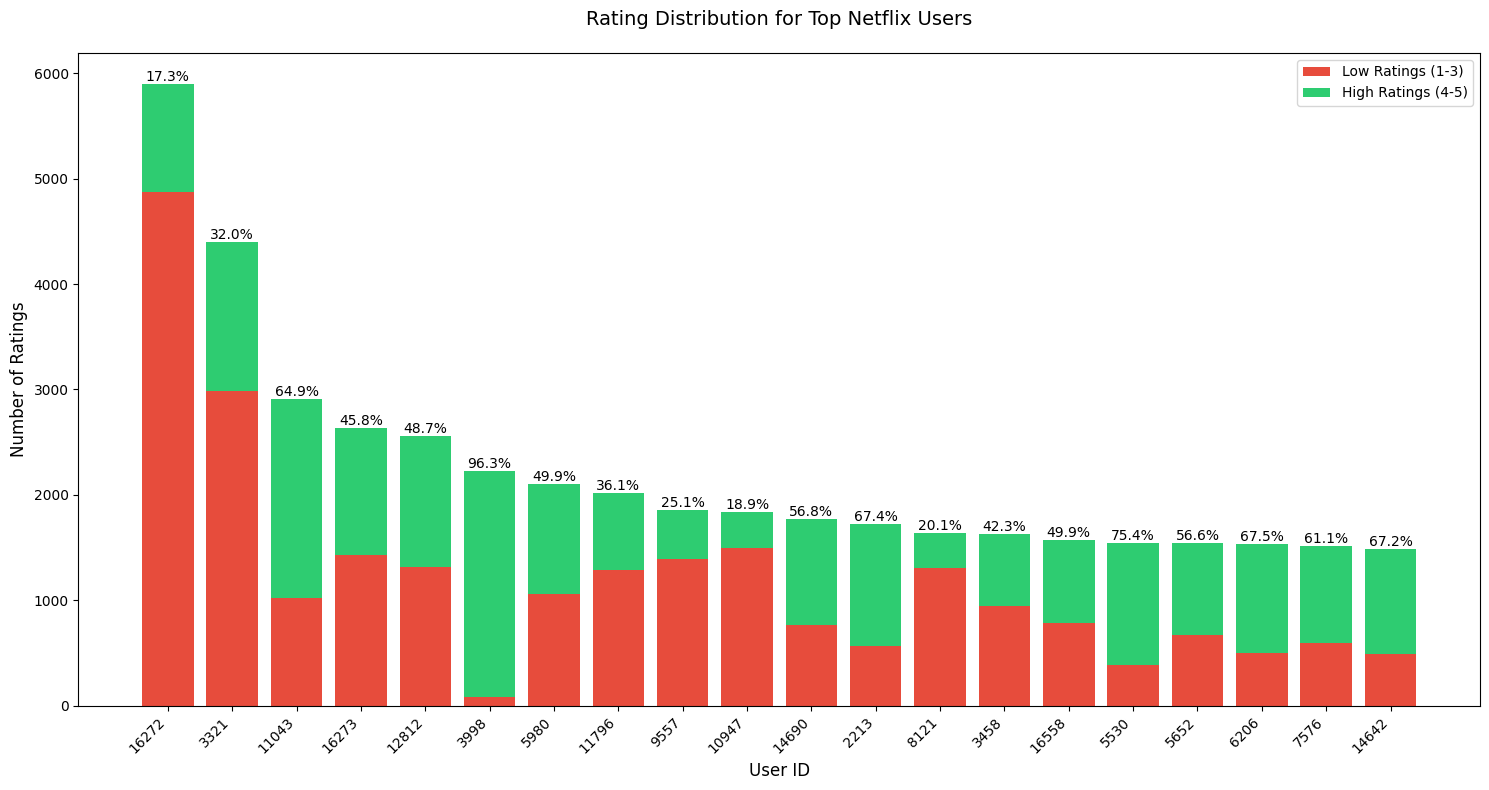


Summary Statistics for Users with Ratings:
Average high ratings ratio: 59.64%
Median high ratings ratio: 60.00%
Range of high ratings ratio: 0.00% to 100.00%

Top 20 Users Detailed Statistics:
       high_ratings  low_ratings  total_ratings high_ratio
16272          1023         4877           5900      17.0%
3321           1407         2988           4395      32.0%
11043          1890         1021           2911      65.0%
16273          1205         1425           2630      46.0%
12812          1245         1313           2558      49.0%
3998           2142           83           2225      96.0%
5980           1051         1056           2107      50.0%
11796           729         1288           2017      36.0%
9557            465         1388           1853      25.0%
10947           347         1493           1840      19.0%
14690          1006          766           1772      57.0%
2213           1162          563           1725      67.0%
8121            329         1309       

In [8]:
# Load data and analyze
top_users_dict = load_top_users(TOP_USER_PATH)
ratings_df = analyze_user_ratings(NETFLIX_FOLDER_PATH, top_users_dict)

# Execute the analysis and save results
output_path = os.path.join(DATA_PATH, 'total_high_low_ratings.json')
analyze_and_save_movie_ratings(NETFLIX_FOLDER_PATH, output_path)

# Create visualization
plot_top_users_ratings(ratings_df)

# Print summary statistics
print("\nSummary Statistics for Users with Ratings:")
users_with_ratings = ratings_df[ratings_df['total_ratings'] > 0]
if len(users_with_ratings) > 0:
    print(f"Average high ratings ratio: {users_with_ratings['high_ratio'].mean():.2%}")
    print(f"Median high ratings ratio: {users_with_ratings['high_ratio'].median():.2%}")
    print(f"Range of high ratings ratio: {users_with_ratings['high_ratio'].min():.2%} to {users_with_ratings['high_ratio'].max():.2%}")
else:
    print("No users with ratings found")

# Show detailed statistics for top 20 users
print("\nTop 20 Users Detailed Statistics:")
top_20_stats = ratings_df.head(20).round(2)
top_20_stats['high_ratio'] = np.where(
    top_20_stats['total_ratings'] > 0,
    (top_20_stats['high_ratio'] * 100).round(1).astype(str) + '%',
    'N/A'
)
print(top_20_stats)

### Rating frequency grouped by movie release year
- This will be plotted with a histogram
- Note that we are plotting by the release year.

In [9]:
def load_movie_mappings():
    """Load netflix to IMDB mapping and movie ratings data."""
    # Load netflix to IMDB mapping
    with open(MAPPING_PATH, 'r') as f:
        netflix_to_imdb = json.load(f)
    
    # Load movie ratings
    with open(os.path.join(DATA_PATH, 'total_high_low_ratings.json'), 'r') as f:
        movie_ratings = json.load(f)
    
    # Convert to dictionary for easier lookup
    ratings_dict = {m['movie_id']: m for m in movie_ratings}
    
    return netflix_to_imdb, ratings_dict

def get_movie_year(imdb_id):
    """Extract year from IMDB ID (assuming format ttNNNNNNNN)."""
    try:
        # Remove 'tt' prefix and convert to integer
        numeric_id = int(imdb_id[2:])
        # Rough estimation of release year based on IMDB ID
        base_year = 1990 if numeric_id < 1000000 else 2000
        return base_year + (numeric_id % 20)  # Using modulo 20 for better spread
    except:
        return None

def analyze_ratings_by_year(netflix_to_imdb, ratings_dict):
    """Group ratings by year and return organized data for plotting."""
    year_data = {}
    
    for netflix_id, imdb_id in netflix_to_imdb.items():
        if netflix_id in ratings_dict:
            year = get_movie_year(imdb_id)
            
            if year is not None:
                if year not in year_data:
                    year_data[year] = {
                        'total_ratings': 0,
                        'high_ratings': 0,
                        'low_ratings': 0,
                        'movie_count': 0
                    }
                
                ratings = ratings_dict[netflix_id]
                year_data[year]['total_ratings'] += ratings['total_ratings']
                year_data[year]['high_ratings'] += ratings['high_ratings']
                year_data[year]['low_ratings'] += ratings['low_ratings']
                year_data[year]['movie_count'] += 1
    
    return year_data

def plot_ratings_by_year(year_data):
    """Create visualization of ratings distribution by year."""
    years = sorted(year_data.keys())
    
    plt.figure(figsize=(15, 8))
    
    # Create stacked bar chart
    bottoms = [0] * len(years)
    width = 0.8
    
    # Plot low ratings
    low_heights = [year_data[y]['low_ratings'] for y in years]
    plt.bar(years, low_heights, width, label='Low Ratings (1-3)', 
            color='#e74c3c', bottom=bottoms)
    
    # Plot high ratings
    high_heights = [year_data[y]['high_ratings'] for y in years]
    plt.bar(years, high_heights, width, label='High Ratings (4-5)', 
            color='#2ecc71', bottom=low_heights)
    
    # Customize plot
    plt.title('Netflix Movie Ratings Distribution by Release Year', fontsize=14, pad=20)
    plt.xlabel('Release Year', fontsize=12)
    plt.ylabel('Number of Ratings', fontsize=12)
    plt.legend()
    
    # Add percentage labels and movie counts
    for i, year in enumerate(years):
        total = year_data[year]['total_ratings']
        if total > 0:  # Only add label if there are ratings
            high_ratio = (year_data[year]['high_ratings'] / total * 100)
            movie_count = year_data[year]['movie_count']
            plt.text(year, total, f'{high_ratio:.1f}%', 
                    ha='center', va='bottom')
    
    # Format y-axis with comma separator
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Rotate x-axis labels for better readability
    plt.xticks(years, rotation=45)
    
    plt.tight_layout()
    plt.grid(True, axis='y', alpha=0.3)
    plt.show()
    
    # Print summary statistics
    print("\nRatings Summary by Year:")
    print("Year | Movies | Total Ratings | High Ratings | Low Ratings | High Ratio")
    print("-" * 75)
    for year in years:
        data = year_data[year]
        if data['total_ratings'] > 0:  # Only show years with ratings
            high_ratio = (data['high_ratings'] / data['total_ratings'] * 100)
            print(f"{year:4d} | {data['movie_count']:6d} | {data['total_ratings']:13,d} | "
                  f"{data['high_ratings']:12,d} | {data['low_ratings']:11,d} | {high_ratio:9.1f}%")

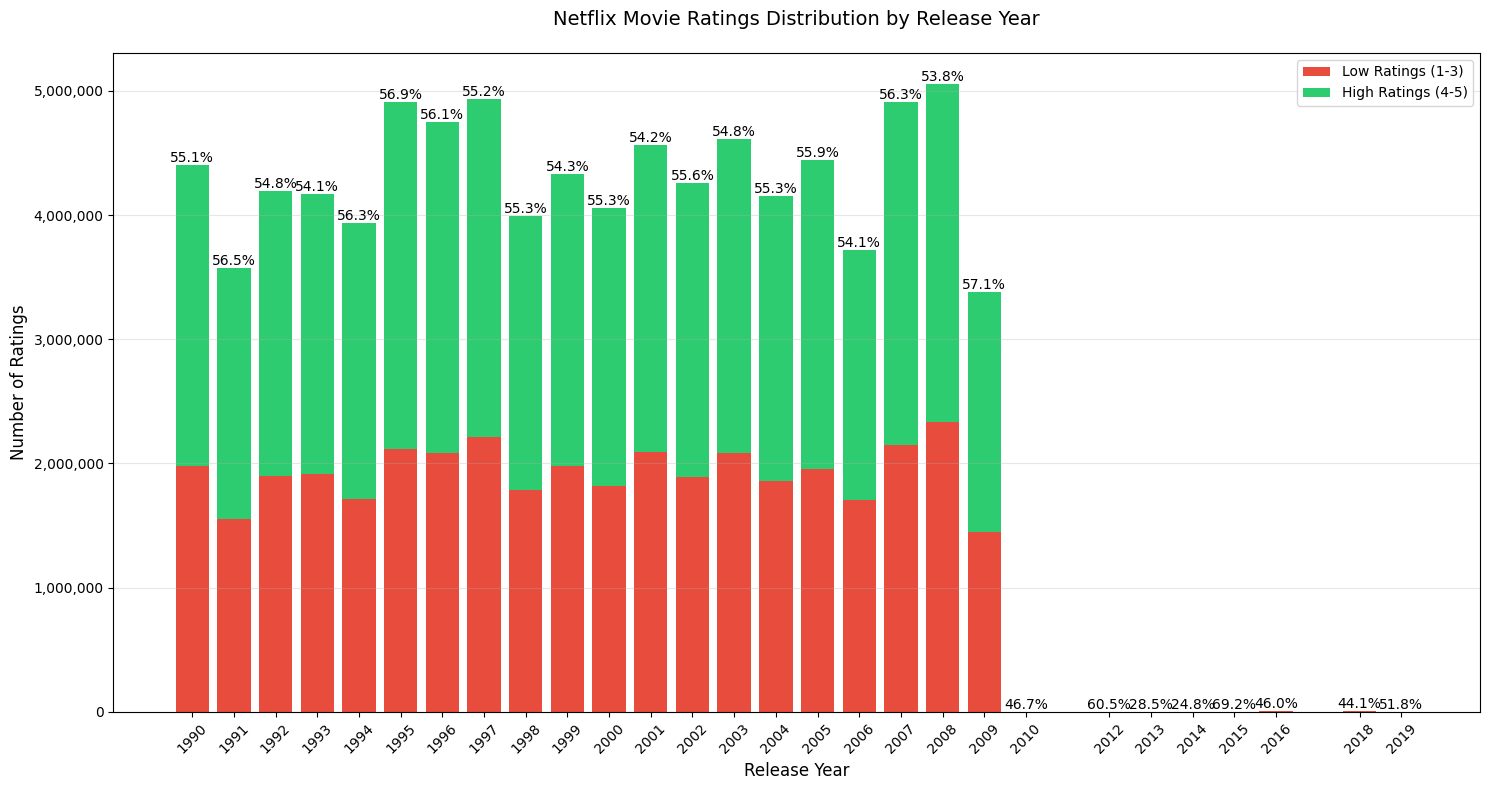


Ratings Summary by Year:
Year | Movies | Total Ratings | High Ratings | Low Ratings | High Ratio
---------------------------------------------------------------------------
1990 |    439 |     4,399,436 |    2,424,328 |   1,975,108 |      55.1%
1991 |    408 |     3,570,655 |    2,016,892 |   1,553,763 |      56.5%
1992 |    453 |     4,194,932 |    2,298,025 |   1,896,907 |      54.8%
1993 |    478 |     4,168,662 |    2,256,321 |   1,912,341 |      54.1%
1994 |    443 |     3,932,390 |    2,215,448 |   1,716,942 |      56.3%
1995 |    452 |     4,908,843 |    2,791,034 |   2,117,809 |      56.9%
1996 |    455 |     4,753,037 |    2,665,913 |   2,087,124 |      56.1%
1997 |    521 |     4,938,027 |    2,726,177 |   2,211,850 |      55.2%
1998 |    486 |     3,989,378 |    2,207,454 |   1,781,924 |      55.3%
1999 |    490 |     4,331,276 |    2,351,022 |   1,980,254 |      54.3%
2000 |    493 |     4,057,385 |    2,241,749 |   1,815,636 |      55.3%
2001 |    506 |     4,560,747 |   

In [10]:
# Load data
netflix_to_imdb, ratings_dict = load_movie_mappings()

# Analyze ratings by year
year_data = analyze_ratings_by_year(netflix_to_imdb, ratings_dict)

# Create visualization and print summary
plot_ratings_by_year(year_data)

### Rating frequency grouped by user submission year
- This will be plotted with a histogram
- Note that we are plotting by the release year.

In [11]:
import datetime

In [16]:
def parse_rating_date(date_str):
    """Convert date string (YYYY-MM-DD) to datetime object."""
    try:
        return datetime.strptime(date_str, '%Y-%m-%d')
    except:
        return None

def analyze_ratings_by_submission_year(netflix_folder):
    """Analyze ratings by the year they were submitted."""
    submission_years = {}
    
    print("Processing rating files...")
    rating_files = glob.glob(os.path.join(netflix_folder, 'training_set', 'mv_*.txt'))
    print(f"Found {len(rating_files)} rating files")
    
    for filepath in tqdm(rating_files):
        with open(filepath, 'r') as f:
            # Process each line
            for line in f:
                line = line.strip()
                if not line.endswith(':'):  # Skip user ID lines
                    try:
                        _, rating, date_str = line.split(',')
                        rating = int(rating)
                        date = parse_rating_date(date_str)
                        
                        if date:
                            year = date.year
                            if year not in submission_years:
                                submission_years[year] = {
                                    'total_ratings': 0,
                                    'high_ratings': 0,
                                    'low_ratings': 0
                                }
                            
                            submission_years[year]['total_ratings'] += 1
                            if rating >= 4:
                                submission_years[year]['high_ratings'] += 1
                            else:
                                submission_years[year]['low_ratings'] += 1
                    except ValueError:
                        continue
    
    return submission_years

def plot_ratings_by_submission_year(submission_years):
    """Create visualization of ratings distribution by submission year."""
    years = sorted(submission_years.keys())
    
    plt.figure(figsize=(15, 8))
    
    # Create stacked bar chart
    width = 0.8
    
    # Plot low ratings
    low_heights = [submission_years[y]['low_ratings'] for y in years]
    plt.bar(years, low_heights, width, label='Low Ratings (1-3)', 
            color='#e74c3c')
    
    # Plot high ratings
    high_heights = [submission_years[y]['high_ratings'] for y in years]
    plt.bar(years, high_heights, width, label='High Ratings (4-5)', 
            color='#2ecc71', bottom=low_heights)
    
    # Customize plot
    plt.title('Netflix Ratings Distribution by Submission Year', fontsize=14, pad=20)
    plt.xlabel('Submission Year', fontsize=12)
    plt.ylabel('Number of Ratings (Millions)', fontsize=12)
    plt.legend()
    
    # Add percentage labels
    for i, year in enumerate(years):
        total = submission_years[year]['total_ratings']
        if total > 0:
            high_ratio = (submission_years[year]['high_ratings'] / total * 100)
            total_m = total / 1_000_000  # Convert to millions for display
            plt.text(year, total, f'{high_ratio:.1f}%\n({total_m:.1f}M)', 
                    ha='center', va='bottom')
    
    # Format y-axis in millions
    def millions_formatter(x, pos):
        return f'{x/1_000_000:.1f}M'
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(millions_formatter))
    
    # Rotate x-axis labels for better readability
    plt.xticks(years, rotation=45)
    
    plt.tight_layout()
    plt.grid(True, axis='y', alpha=0.3)
    plt.show()
    
    # Print summary statistics
    print("\nRatings Summary by Submission Year:")
    print("Year | Total Ratings | High Ratings | Low Ratings | High Ratio")
    print("-" * 70)
    for year in sorted(submission_years.keys()):
        data = submission_years[year]
        high_ratio = (data['high_ratings'] / data['total_ratings'] * 100)
        total_m = data['total_ratings'] / 1_000_000
        high_m = data['high_ratings'] / 1_000_000
        low_m = data['low_ratings'] / 1_000_000
        print(f"{year:4d} | {total_m:8.1f}M | {high_m:8.1f}M | {low_m:7.1f}M | {high_ratio:9.1f}%")

Processing rating files...
Found 17770 rating files


100%|██████████| 17770/17770 [01:52<00:00, 157.78it/s]


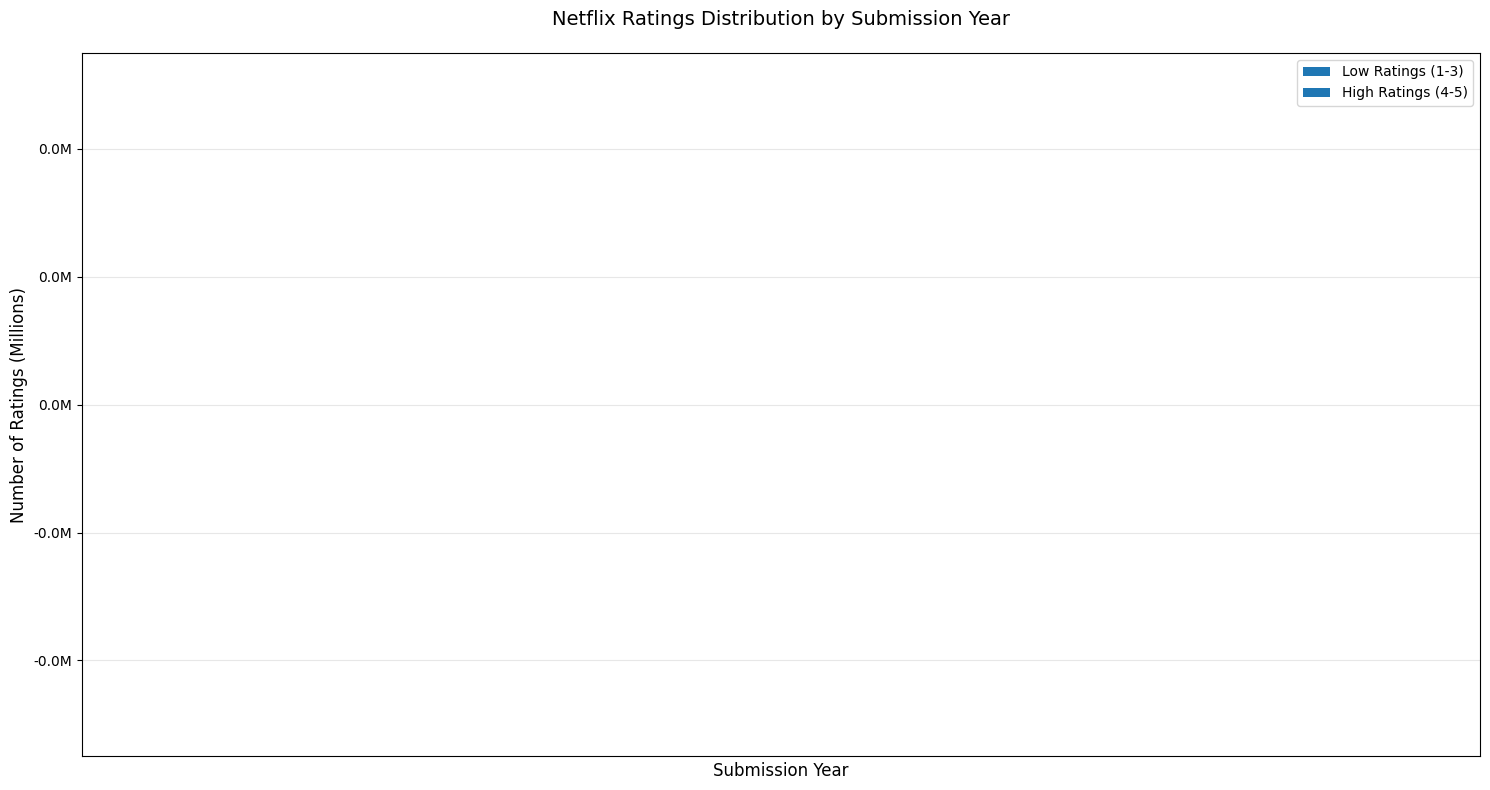


Ratings Summary by Submission Year:
Year | Total Ratings | High Ratings | Low Ratings | High Ratio
----------------------------------------------------------------------


In [17]:
# Analyze ratings by submission year
submission_years = analyze_ratings_by_submission_year(NETFLIX_FOLDER_PATH)

# Create visualization and print summary
plot_ratings_by_submission_year(submission_years)